## Description

**Author: Łukasz Łaszczuk**

This notebook focuses on exploratory data analysis, visualization and determining baseline scores of some classification algorithms.

## Importing modules and loading data

In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("data\data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)

## First look into the data

In [6]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
106952,162027.0,-1.622031,1.972587,-0.783677,-0.428035,-0.251014,-0.009635,-1.898511,-5.824547,-0.849873,...,-1.929508,0.029571,0.718311,0.006183,-0.612842,0.097726,-0.099411,-0.026313,1.79,0
8194,117224.0,1.875883,0.347340,0.268069,3.846551,-0.180831,0.344992,-0.450978,0.043994,-0.427694,...,0.233077,0.863230,0.117490,-0.089824,-0.125003,0.090317,0.024443,-0.030703,6.06,0
38018,27573.0,1.124939,0.222151,0.545396,1.474345,-0.278641,-0.360735,0.119169,-0.066327,0.197827,...,-0.069596,0.037985,-0.035518,0.421357,0.631657,-0.334918,0.041755,0.021745,17.18,0
17213,61149.0,1.241278,0.411931,0.320964,0.688973,-0.276909,-1.042955,0.176001,-0.271585,-0.143321,...,-0.269346,-0.739650,0.108285,0.377405,0.252128,0.089658,-0.017074,0.034733,9.99,0
178455,161286.0,1.454610,-1.291162,-0.865050,0.483261,-0.800952,-0.273181,-0.224679,-0.051093,1.448121,...,0.383158,0.579871,-0.090265,0.728490,-0.167937,-0.623305,-0.004517,0.022385,292.00,0


In [7]:
df.shape

(213605, 31)

In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213605 entries, 0 to 213604
Data columns (total 31 columns):
Time      213605 non-null float64
V1        213605 non-null float64
V2        213605 non-null float64
V3        213605 non-null float64
V4        213605 non-null float64
V5        213605 non-null float64
V6        213605 non-null float64
V7        213605 non-null float64
V8        213605 non-null float64
V9        213605 non-null float64
V10       213605 non-null float64
V11       213605 non-null float64
V12       213605 non-null float64
V13       213605 non-null float64
V14       213605 non-null float64
V15       213605 non-null float64
V16       213605 non-null float64
V17       213605 non-null float64
V18       213605 non-null float64
V19       213605 non-null float64
V20       213605 non-null float64
V21       213605 non-null float64
V22       213605 non-null float64
V23       213605 non-null float64
V24       213605 non-null float64
V25       213605 non-null float64
V26  

**Note:** All columns (except Class) contain numerical data (float64 type). While building models, we will convert them to float32 type to speed up computations.

**Let's check for duplicated transactions**

In [22]:
duplicates = df[df.duplicated(keep=False)].sort_values(["Time","V1"])
n_dup = duplicates.shape[0]  # Number of all duplicated transactions
n_dup

1138

In [21]:
duplicated_frauds = duplicates[duplicates["Class"] == 1]
n_dup_frauds = duplicated_frauds.shape[0]  # Number of duplicated frauds
n_dup_frauds

17

In [20]:
# Take a look into duplicated frauds
duplicated_frauds.loc[:, ["Time", "Amount"]]

,Time,Amount
14758,68207.0,1.00
88046,68207.0,1.00
125126,68207.0,1.00
177662,68207.0,1.00
206339,68207.0,1.00
188237,85285.0,0.00
197302,85285.0,0.00
47737,85285.0,252.92
94615,85285.0,252.92
5592,93853.0,44.90


In [27]:
# Compare with legal transactions
duplicates.loc[:, ["Time","Amount"]].head(20)

,Time,Amount
98296,26.0,1.77
189918,26.0,1.77
1849,26.0,6.14
62444,26.0,6.14
48697,74.0,1.18
68067,74.0,1.18
77447,74.0,1.18
94099,74.0,1.18
386,145.0,6.00
164738,145.0,6.00


In [23]:
100*n_dup_frauds / n_dup  # percentage of frauds in duplicates

1.4938488576449913

**Note:**
- There are 1138 duplicate transaction, which accounts for ca. 0.46% of all transactions;
- There are 17 duplicate frauds, which accounts for ca. 4.6% of all fraudulent transactions;
- It's hard to see any pattern in duplicated frauds, due to low quantity;
- For now, we will leave the duplicates in the data.

**Let's check for missing data**

In [9]:
df.isnull().any().any()  # The data doesn't contain any missing values

False

In [10]:
df.drop(["Time", "Amount", "Class"], axis=1).describe()  # Descriptive statistics for V columns

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,0.000761,-0.000864,-0.000395,-0.000124,0.000037,-0.001235,-0.000793,0.000741,0.002086,-0.002382,...,-0.000233,0.000381,0.000008,0.000888,-0.000716,-0.000077,0.000786,0.000293,-0.000320,-0.000183
std,1.959843,1.656822,1.514786,1.412014,1.367172,1.324434,1.218273,1.194886,1.098027,1.087479,...,0.813287,0.765076,0.729790,0.726021,0.632531,0.605641,0.522326,0.482457,0.401070,0.328280
min,-56.407510,-72.715730,-33.680984,-5.683171,-42.147900,-26.160505,-43.557243,-50.943367,-13.434067,-24.588263,...,-7.213527,-23.646890,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565680,-11.710896
25%,-0.919923,-0.597928,-0.891674,-0.845828,-0.693702,-0.768408,-0.555589,-0.208845,-0.639825,-0.535966,...,-0.456560,-0.211881,-0.228160,-0.541214,-0.161916,-0.353719,-0.316995,-0.327013,-0.070970,-0.052880
50%,0.019950,0.065295,0.180284,-0.018836,-0.055078,-0.274951,0.040626,0.022431,-0.048788,-0.094571,...,0.003635,-0.063053,-0.029198,0.007580,-0.011943,0.041112,0.017457,-0.052342,0.001158,0.011244
75%,1.315599,0.803606,1.028480,0.743107,0.611668,0.398197,0.569214,0.327296,0.599340,0.449416,...,0.457928,0.131932,0.186690,0.527844,0.146825,0.439075,0.352142,0.241358,0.090808,0.078129
max,2.451889,22.057730,9.382559,16.875343,34.801666,23.917837,44.054462,19.587772,15.594995,23.745136,...,5.591971,39.420906,27.202839,8.361985,20.803345,4.016342,7.519588,3.517346,12.152401,33.847810


In [11]:
df.loc[:, ["Amount", "Time"]].describe()  # descriptive statistics for Amount and Time

,Amount,Time
count,213605.000000,213605.000000
mean,88.408696,94763.710592
std,248.726927,47521.370536
min,0.000000,0.000000
25%,5.580000,54113.000000
50%,22.000000,84629.000000
75%,77.010000,139282.000000
max,19656.530000,172792.000000


In [30]:
100 * df["Class"].value_counts(normalize=True)  # check proportion between classes

0    99.827251
1     0.172749
Name: Class, dtype: float64

**Note**: 
- The data doesn't contain any missing values;
- There are 30 explanatory variables (floats) and 1 target variable ("Class", int).
- V columns contain normalized and anonymized features. If we look at maxima and minima, we can see extreme (positive and negative) values. It indicates that there might exist outliers in the data.
- Mean Amount equals ca. 88.4. The median is 22, thus we can say Amount distribution is highly right-skewed.
- The proportion of Class variable is strongly unbalanced.

## Further EDA

Create two subsets of initial DataFrame containing only frauds or only non-fraud transactions. Additionally create undersampled subset (for visualizing pairplots) and add feature "hour" which stands for hour of the day.

In [82]:
# create a feature "hour of the day"
seconds_in_day = 86400
seconds_in_hour = 3600
df["hour"] = (df["Time"]%seconds_in_day) // seconds_in_hour

df_frauds = df[df["Class"] == 1]
df_no_frauds = df[df["Class"] == 0]

n_row_frauds = df_frauds.shape[0]
df_no_frauds_unsmpl = df_no_frauds.sample(n_row_frauds)
df_unsmpl = pd.concat([df_frauds, df_no_frauds_unsmpl])

**Create histograms of V variables to have an overall look at the dataset**

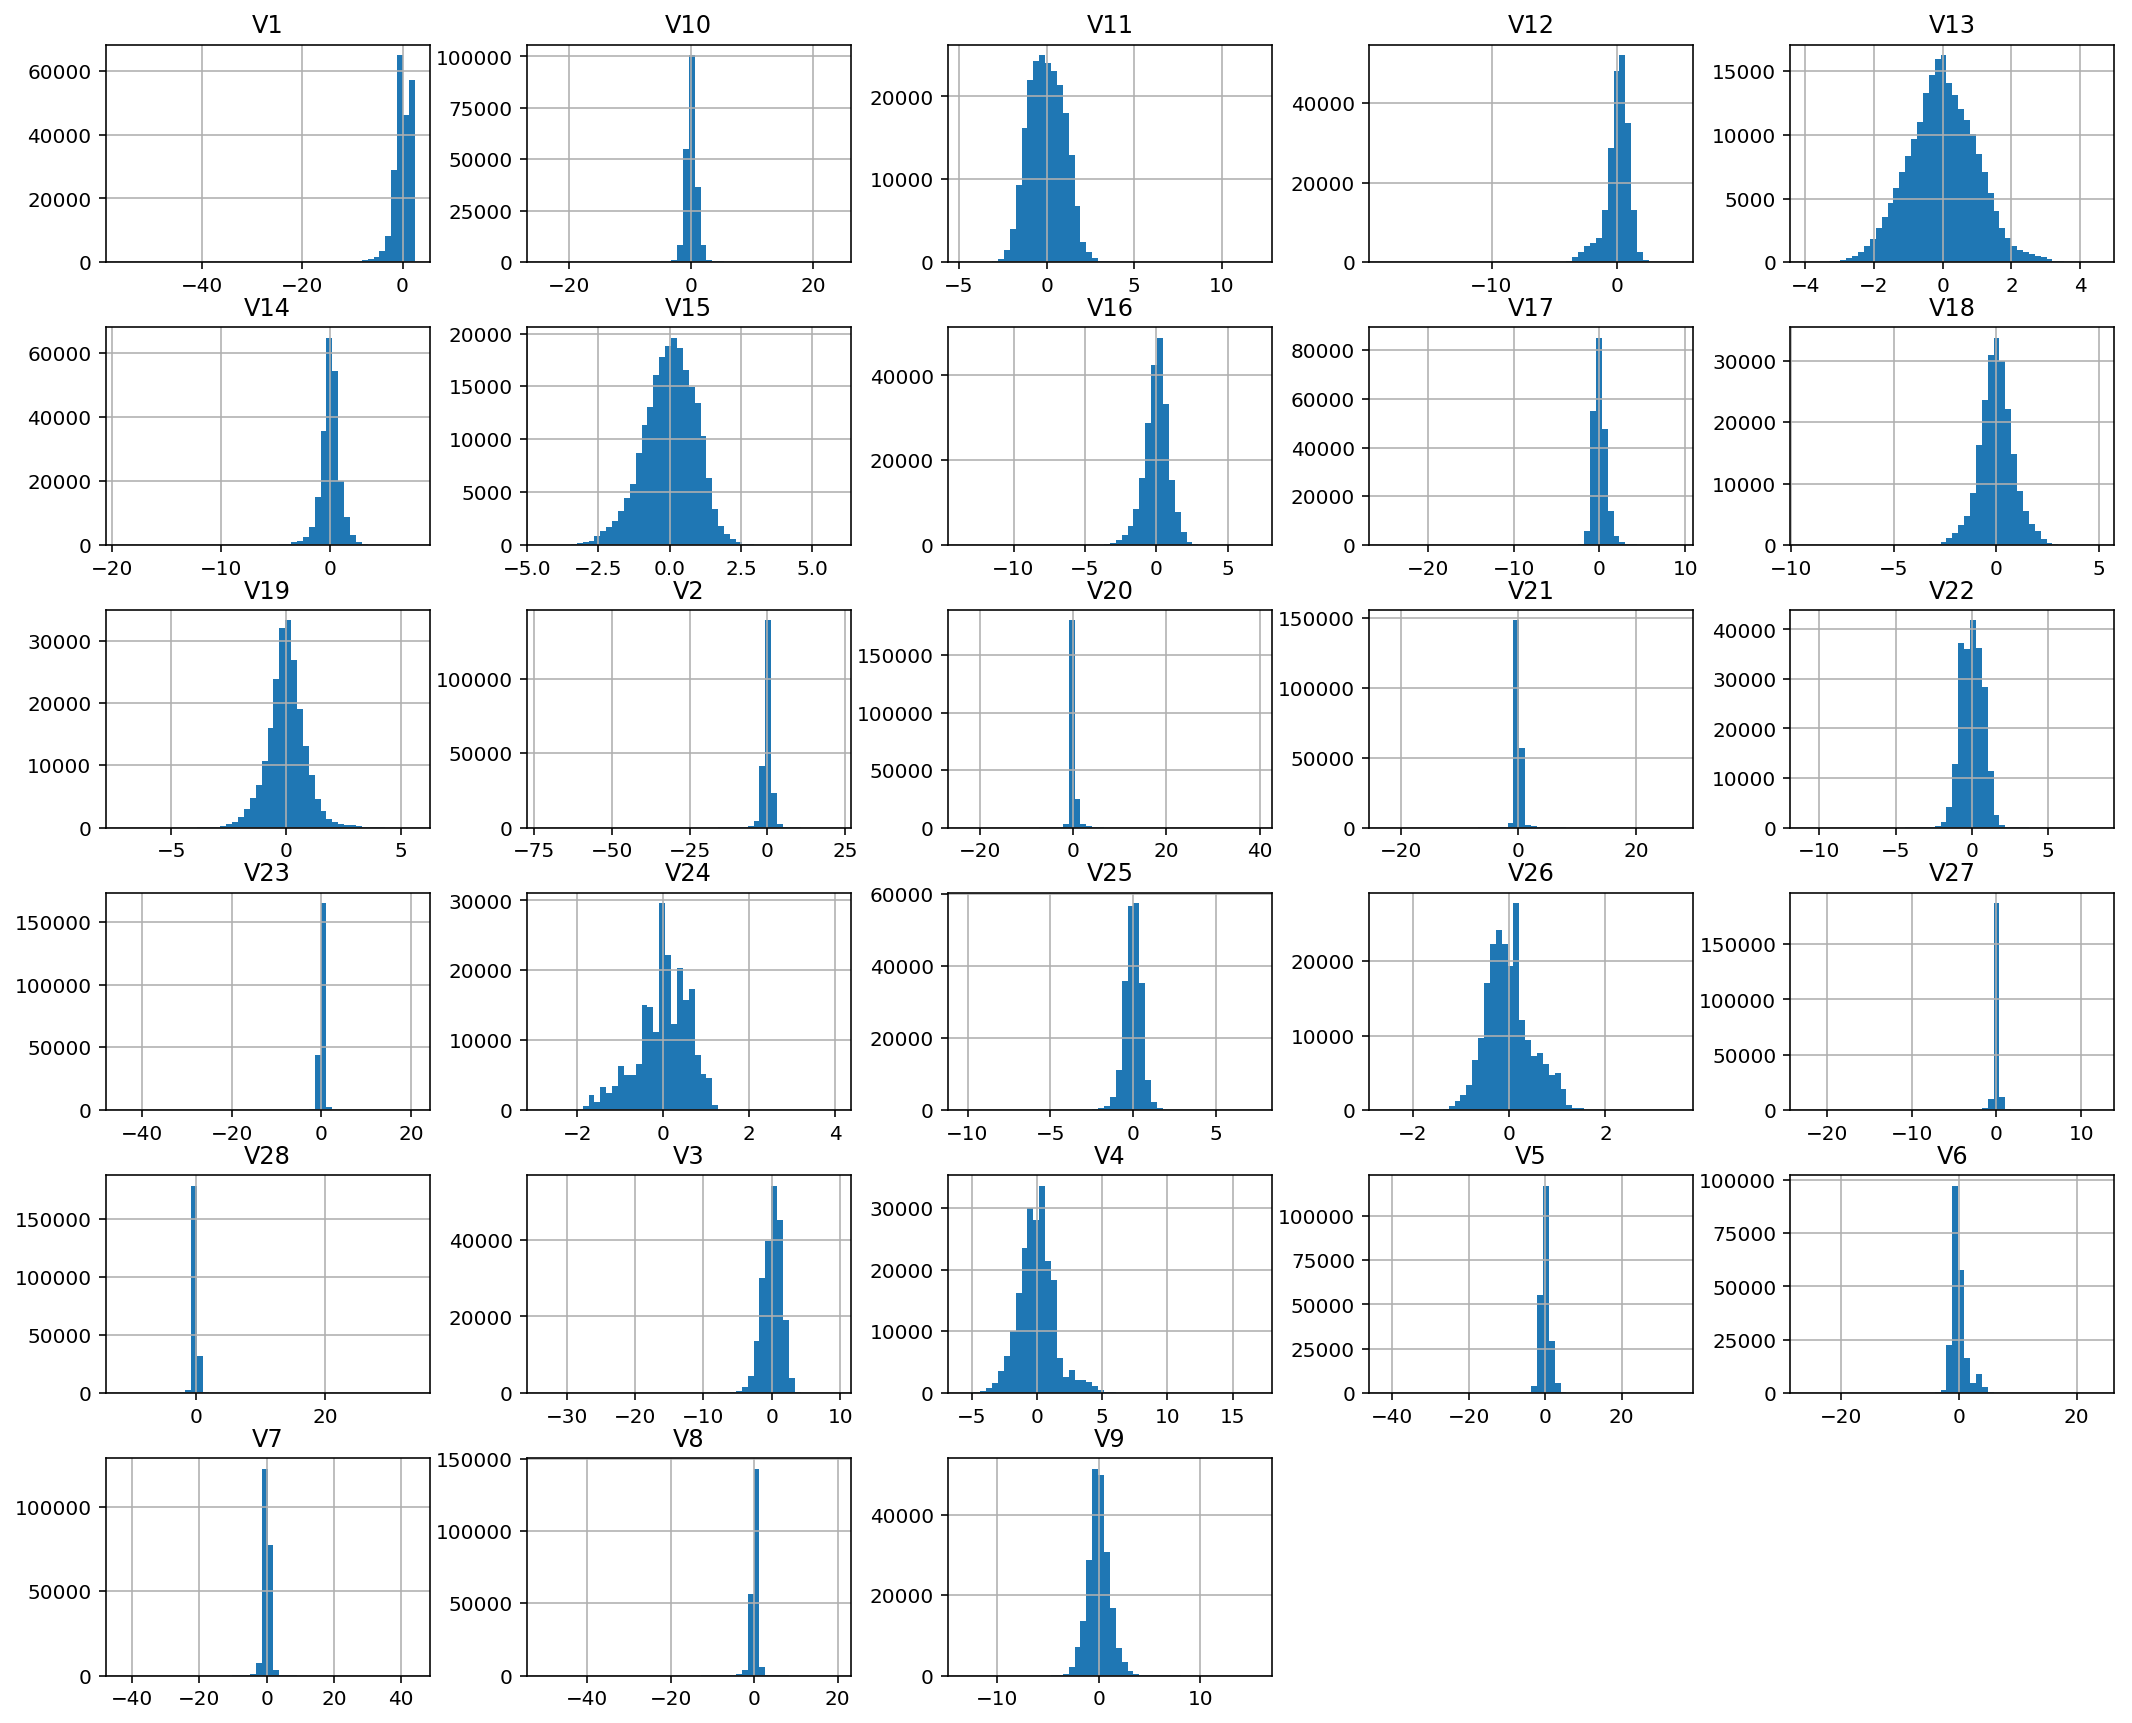

In [14]:
plot = df.drop(["Class", "Amount", "Time"], axis=1).hist(bins=50,
                                                         figsize=(18, 15));

**Create pairplots of some of V variables to check their distributions and see wheter frauds are distinguishable from non-frauds just by looking at the data (the features were chosen after training decision tree checking feature importances).**

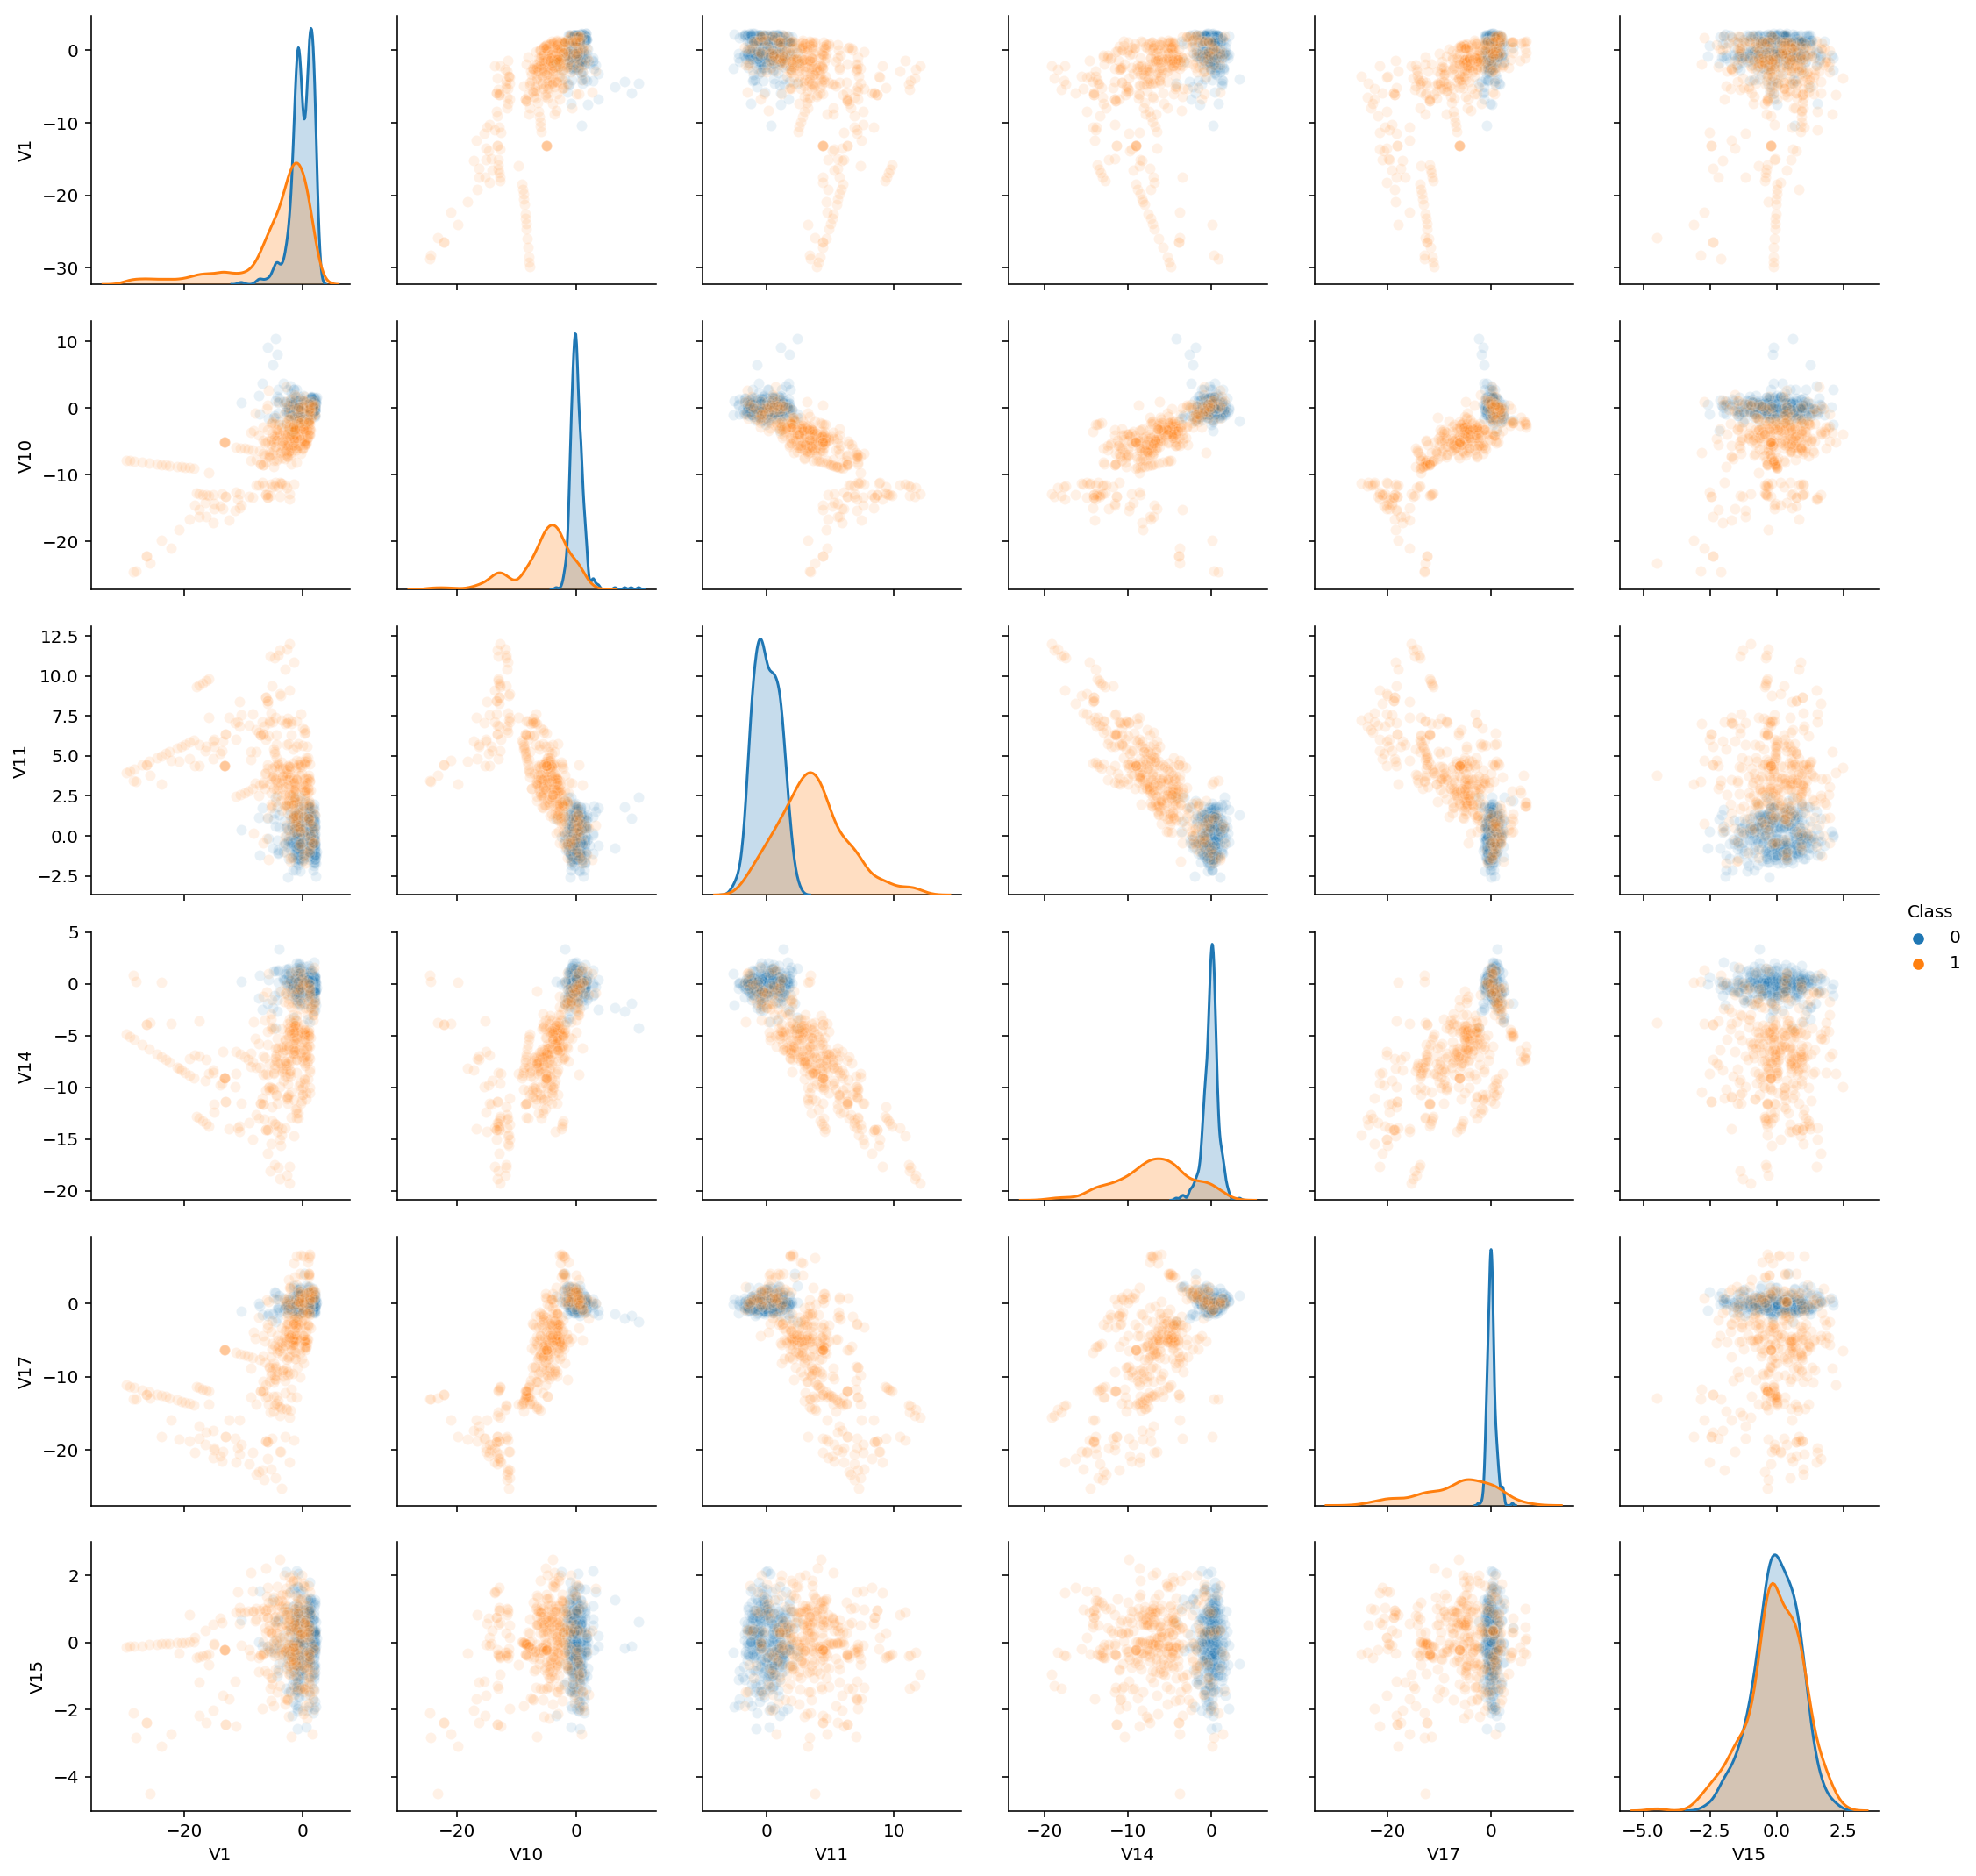

In [37]:
g = sns.pairplot(df_unsmpl, hue="Class", vars = ["V1", "V10", "V11", "V14", "V17", "V15"],
             plot_kws={"alpha": 0.1});

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]

**Note:**
- Distributions of fraudulent transactions tend to have higher variance. For some parameters (like V15) the distributions look almost identical.
- We can see that with undersampled data, it is possible to distinguish between the classes "by hand", just by looking on the scatter plots.

### Amount Analysis

In [33]:
df_frauds["Amount"].describe()

count     369.000000
mean      110.438157
std       221.502314
min         0.000000
25%         1.000000
50%         9.820000
75%       105.990000
max      2125.870000
Name: Amount, dtype: float64

In [34]:
df_no_frauds["Amount"].describe()

count    213236.000000
mean         88.370575
std         248.770228
min           0.000000
25%           5.640000
50%          22.000000
75%          77.000000
max       19656.530000
Name: Amount, dtype: float64

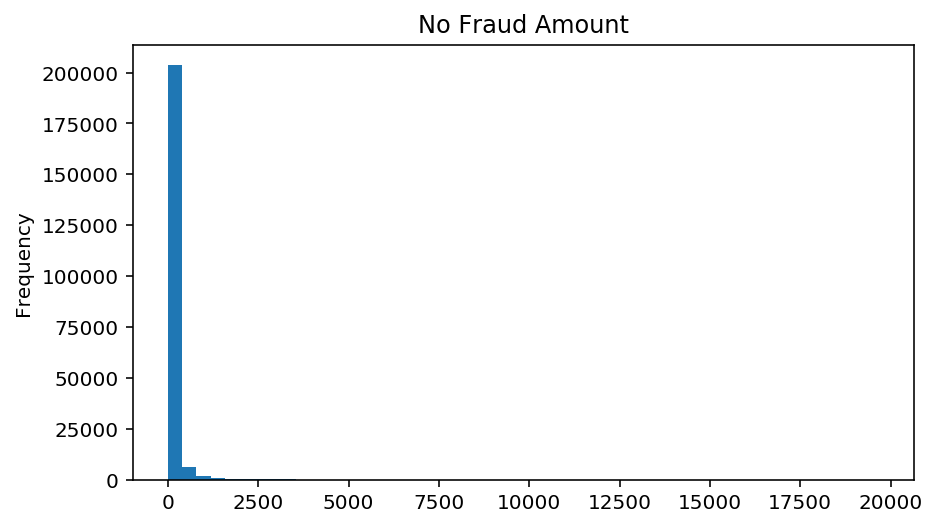

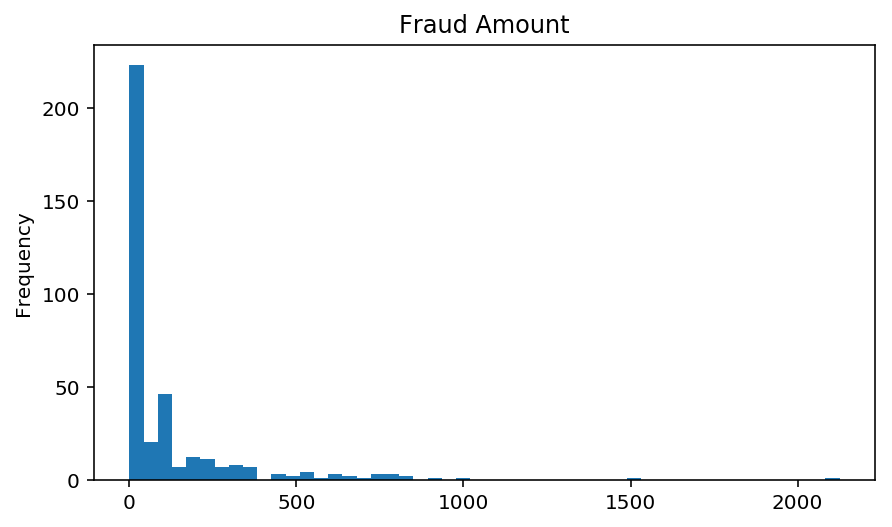

In [43]:
df_no_frauds["Amount"].plot(kind="hist", bins=50, figsize=(7,4), title="No Fraud Amount");
plt.figure()
df_frauds["Amount"].plot(kind="hist", bins=50, figsize=(7,4), title="Fraud Amount");

**Note:** 
- Fraud transactions are not concluded on extreme amounts (likely because big transactions need to be automatically checked);
- Frauds have larger mean than non-frauds;
- Since very large values of amount exist, it might be helpful to use some kind of transformation (for example log10(1+a) or log1p) to scale the data for building the model. This approach keeps the information and allows for new extremely large observations.

**Let's check how does amount variable look like after the transformation.**

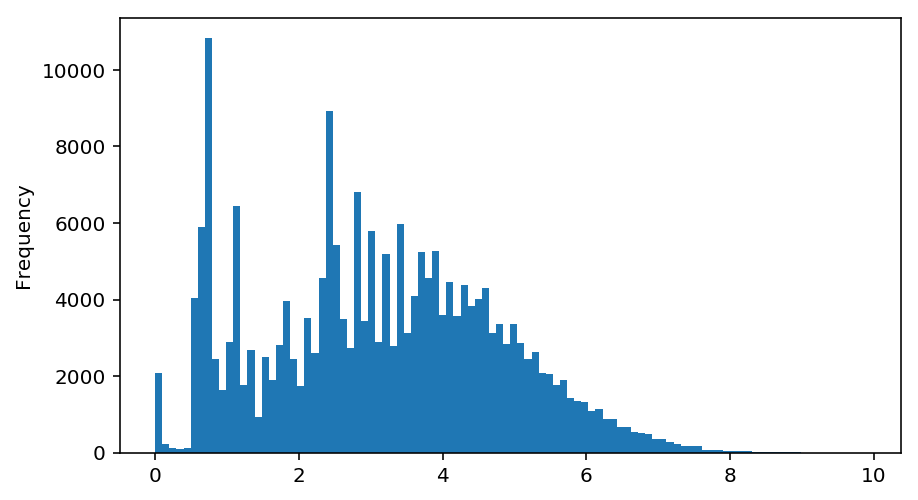

In [47]:
scaled_amount = np.log1p(df["Amount"])
scaled_amount.plot(kind="hist", bins=100, figsize=(7,4));

**For now, we will stick to original amount values, to get better understanding of the data**

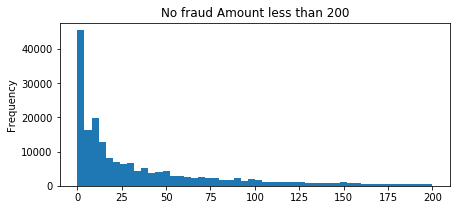

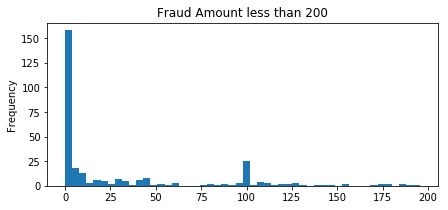

In [28]:
df_no_frauds[df_no_frauds["Amount"] < 200]["Amount"].plot(kind="hist",bins=50,
                                           figsize=(7,3),
                                           title="No fraud Amount less than 200")
plt.figure()
df_frauds[df_frauds["Amount"] < 200]["Amount"].plot(kind="hist",bins=50,
                                           figsize=(7,3),
                                           title="Fraud Amount less than 200");

**Note:**
- Fraudulent transactions have visible peak near the value of 100. Later, we will investigate this observation further.

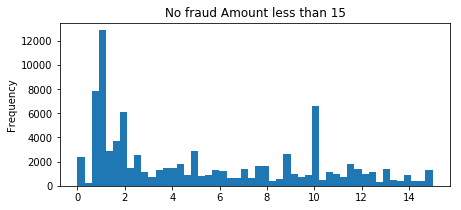

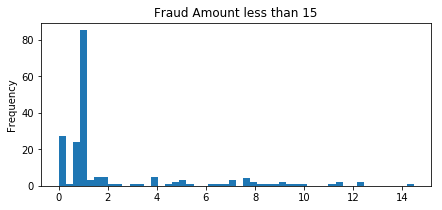

In [29]:
df_no_frauds[df_no_frauds["Amount"] < 15]["Amount"].plot(kind="hist",bins=50,
                                           figsize=(7,3),
                                           title="No fraud Amount less than 15");
plt.figure()
df_frauds[df_frauds["Amount"] < 15]["Amount"].plot(kind="hist", bins=50,
                                      figsize=(7,3),
                                      title="Fraud Amount less than 15");

**Note:**
- Frauds don't have a peak in the area of 10. There are 3 dominant values in fraud transactions.

### Most popular fraud amounts vs most popular non-fraud amounts

In [47]:
100 * df_frauds["Amount"].value_counts(normalize=True).head(6)

1.00     22.493225
0.00      5.962060
99.99     5.691057
0.76      3.523035
0.77      1.897019
2.00      1.084011
Name: Amount, dtype: float64

In [46]:
100 * df_no_frauds["Amount"].value_counts(normalize=True).head(6)

1.00     4.792343
1.98     2.128158
0.89     1.716408
9.99     1.651222
15.00    1.152713
10.00    1.057983
Name: Amount, dtype: float64

***Transactions concluded on 0.00 account for 5.96% of frauds. Let's check how it is for non-frauds.*** 

In [74]:
100 * df_no_frauds[df_no_frauds["Amount"] == 0.00].shape[0] / df.shape[0]

0.6362210622410525

**Note:** 
- Value 0.00 is far more frequent for frauds than non-frauds.

### Closer look into transactions  concluded on 99.99 (the peak we noticed at "amount < 200" histogram)

In [48]:
100 * df_no_frauds[df_no_frauds["Amount"] == 99.99]["Amount"].value_counts() \
    / df_no_frauds.shape[0]

99.99    0.111613
Name: Amount, dtype: float64

In [49]:
100 * df_frauds[df_frauds["Amount"] == 99.99]["Amount"].value_counts() \
    / df_frauds.shape[0]

99.99    5.691057
Name: Amount, dtype: float64

**Note:** 
- Transactions with value equal to 99.99 account for large amount of frauds, while they are not that frequent for non-frauds.

**It is suspicious that the transactions were concluded on 99.99, not on 100.00. Let's check if 99.99 frauds occur sequentially (funneling).**

In [54]:
"""
Create DataFrames containing only fraudulent and legal transactions concluded on
most common fraud amounts (1.00, 99.99, 0.00).
"""

df_frauds_99 = df[(df["Amount"]==99.99) & (df["Class"]==1)]
df_no_frauds_99 = df[(df["Amount"]==99.99) & (df["Class"]==0)]
df_99 = df[(df["Amount"]==99.99)]

df_frauds_0 = df[(df["Amount"]==0.00) & (df["Class"]==1)]
df_no_frauds_0 = df[(df["Amount"]==0.00) & (df["Class"]==0)]

df_frauds_1 = df[(df["Amount"]==1.00) & (df["Class"]==1)]
df_no_frauds_1 = df[(df["Amount"]==1.00) & (df["Class"]==0)]

In [75]:
df_frauds_99 = df_frauds_99.sort_values(by=["Time", "V1"])
df_frauds_99["diff"] = df_frauds_99["Time"].diff()  # time difference between each 99.99 transaction
df_frauds_99.loc[:, ["Time", "diff", "hour", "Amount"]]

,Time,diff,hour,Amount
54808,25198.0,NaN,6.0,99.99
194585,26523.0,1325.0,7.0,99.99
17547,26556.0,33.0,7.0,99.99
7647,26585.0,29.0,7.0,99.99
121147,26833.0,248.0,7.0,99.99
169207,26863.0,30.0,7.0,99.99
204509,26931.0,68.0,7.0,99.99
74844,26961.0,30.0,7.0,99.99
149630,27163.0,202.0,7.0,99.99
118011,27187.0,24.0,7.0,99.99


**Note:** 
- Fraudulent transactions with value 99.99 were frequently concluded in groups. Time between each transaction in group equals ca. 30s. 
- Most of them were taken between 6:00 and 7:00;
- It might be helpful to create a feature (0/1 value), which would group transactions concluded on certain amount (for example 99.99) during time interval (for example 10 minutes). 

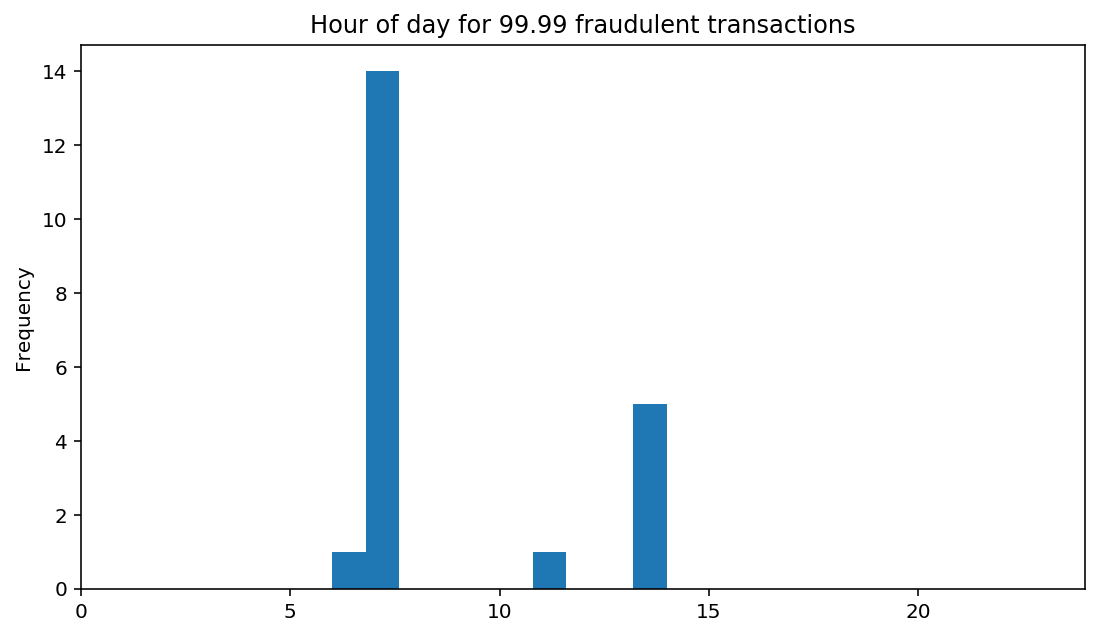

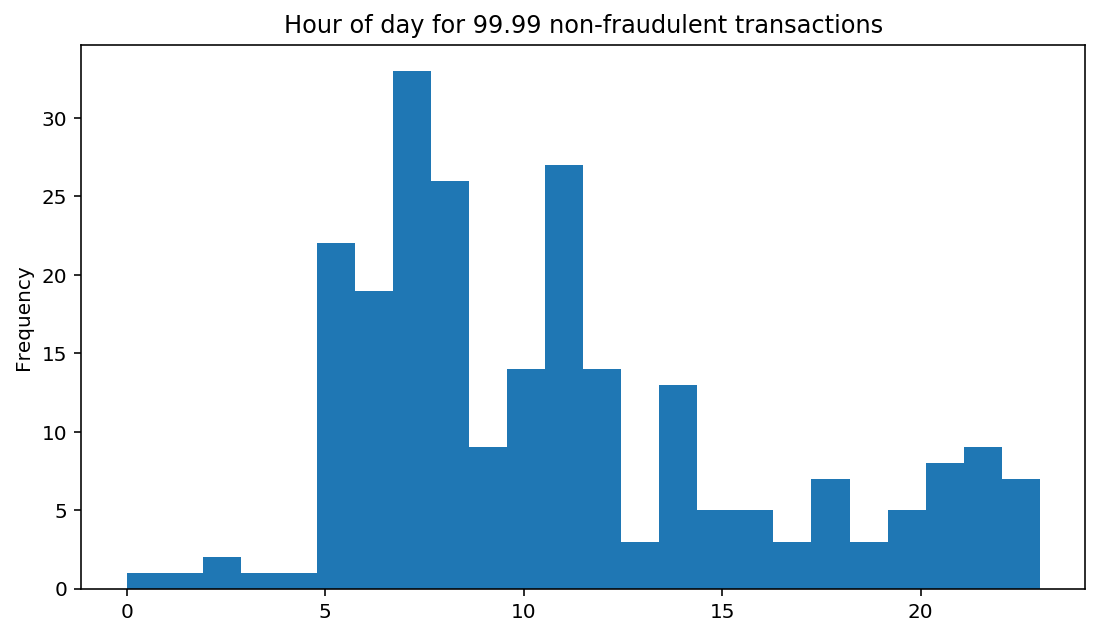

In [53]:
df_frauds_99["hour"].plot(kind="hist",bins=10, xlim=(0,24),
                          figsize=(9,5), title="Hour of day for 99.99 fraudulent transactions", );
plt.figure()
df_no_frauds_99["hour"].plot(kind="hist",bins=24, figsize=(9,5), title="Hour of day for 99.99 non-fraudulent transactions");

**Taking into consideration class imbalance, we can say that the number of frauds taken on 99.99 between 6 and 7 am. is significant.** 

**Now let's see if something similar occurs for 1.00 transactions. We'll show only frauds concluded in groups (time difference smalller than 2 minutes).**

In [71]:
df_frauds_1 = df_frauds_1.sort_values(by=["Time", "V1"])
df_frauds_1["diff"] = df_frauds_1["Time"].diff()  # time difference between each 1.00 transaction
df_frauds_1[df_frauds_1["diff"] < 120].loc[:, ["Time", "diff", "hour", "Amount"]]

,Time,diff,hour,Amount
32525,7526.0,7.0,2.0,1.0
41262,7535.0,9.0,2.0,1.0
212910,7543.0,8.0,2.0,1.0
167496,7551.0,8.0,2.0,1.0
49540,7610.0,59.0,2.0,1.0
117603,7672.0,62.0,2.0,1.0
165660,7740.0,68.0,2.0,1.0
52876,8451.0,36.0,2.0,1.0
204525,8528.0,77.0,2.0,1.0
137645,8886.0,8.0,2.0,1.0


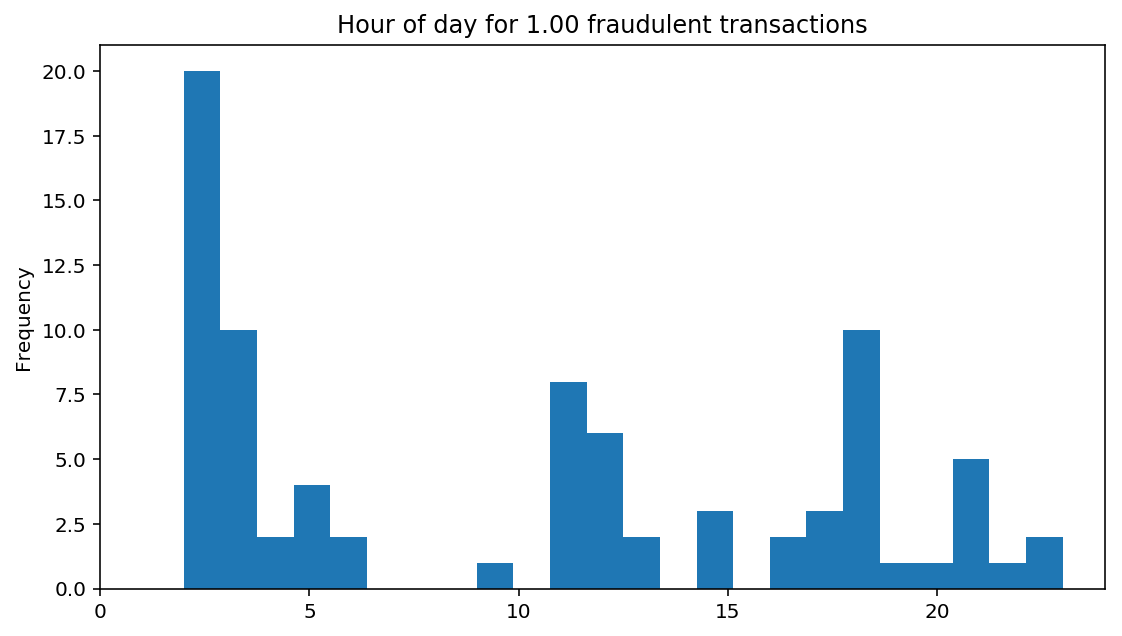

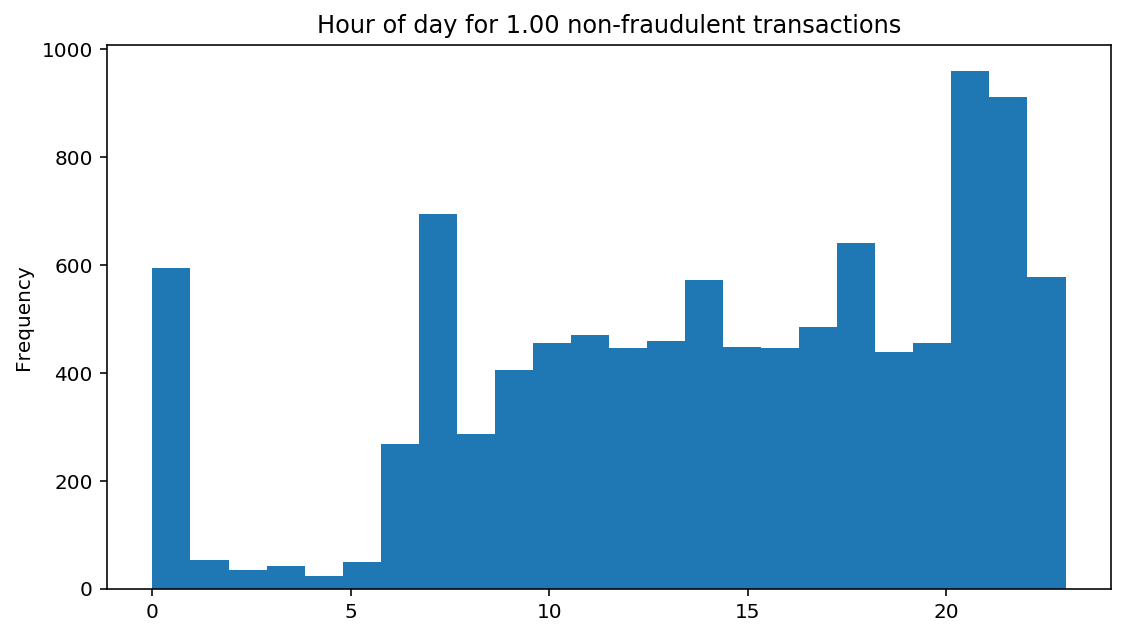

In [67]:
df_frauds_1["hour"].plot(kind="hist",bins=24, xlim=(0,24),
                          figsize=(9,5), title="Hour of day for 1.00 fraudulent transactions", );
plt.figure()
df_no_frauds_1["hour"].plot(kind="hist",bins=24, figsize=(9,5), title="Hour of day for 1.00 non-fraudulent transactions");

**Note:** 
- 1.00 frauds are frequent during night/morning. We can see that non-fraud frequency is low during night/morning.

### Time analysis

**Raw values**

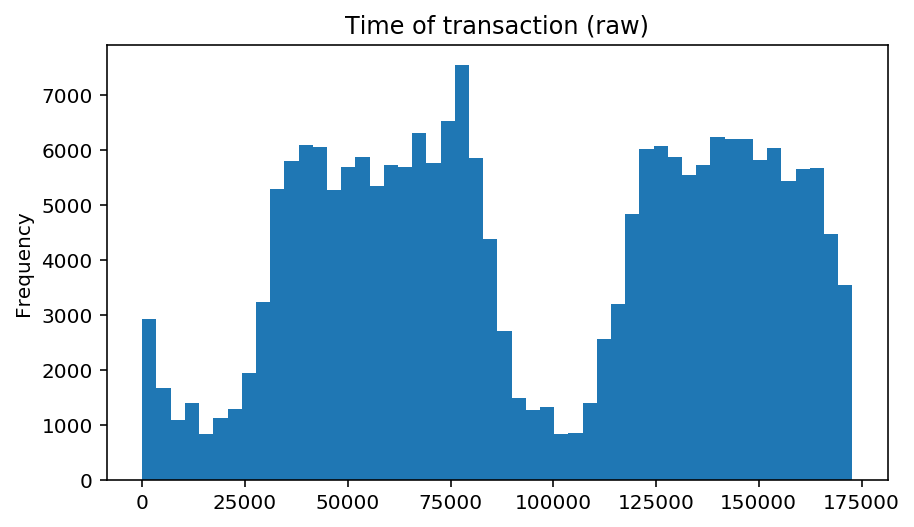

In [77]:
df["Time"].plot(kind="hist",bins=50, figsize=(7,4), title="Time of transaction (raw)");

**Time converted to hour of day for all transactions** <br>
We use "hour" feature which was created at the beggining of EDA section.

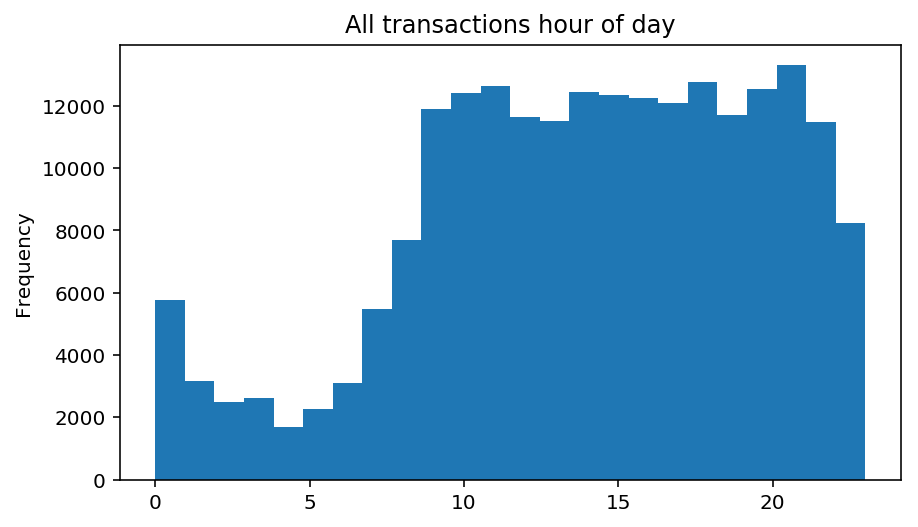

In [84]:
df["hour"].plot(kind="hist", bins=24, figsize=(7,4), title="All transactions hour of day");

**Comparison of hour of day for fraud and non-fraud transactions**

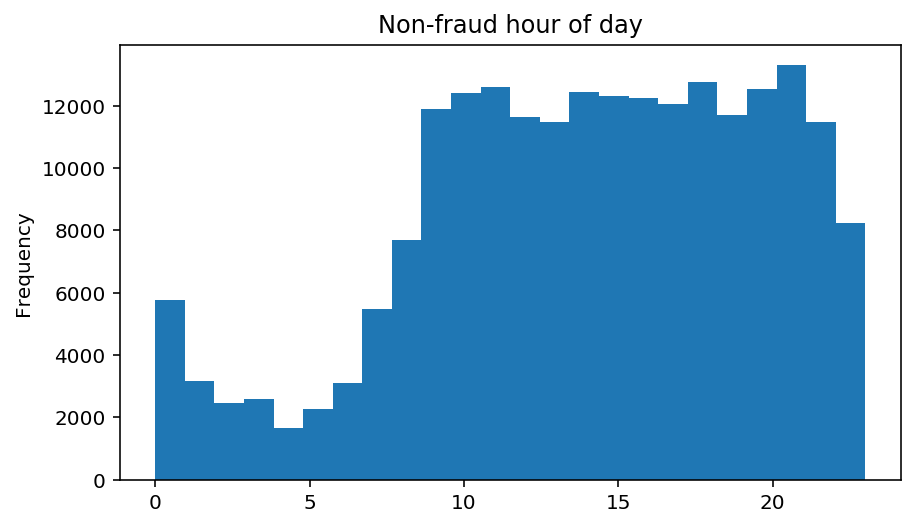

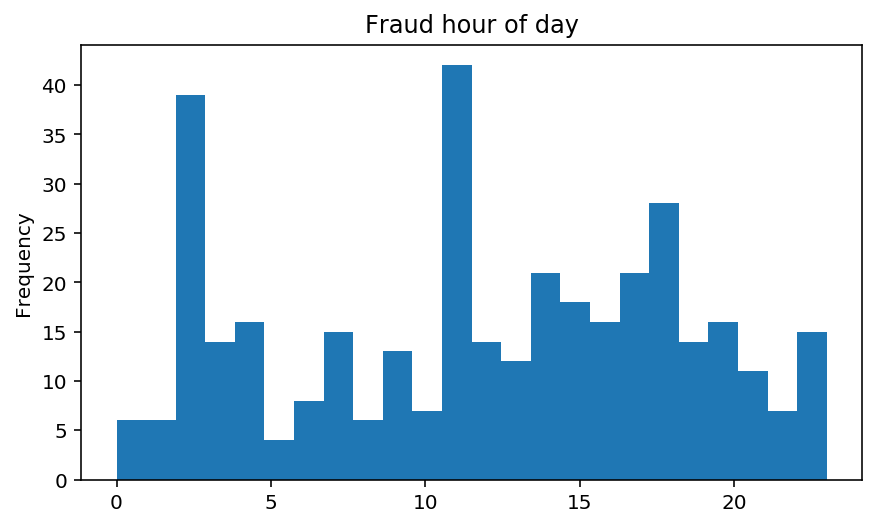

In [85]:
df_no_frauds["hour"].plot(kind="hist", bins=24, figsize=(7,4), title="Non-fraud hour of day");
plt.figure()
df_frauds["hour"].plot(kind="hist", bins=24, figsize=(7,4), title="Fraud hour of day");

**Note:**
- Non-fraud transactions are less frequent during night / early morning;
- Frauds are frequent during night.

### Creating time features understandable by a model 
Raw "Time" variable contains very large values and doesn't consider periodic nature of day. Building a model using raw time will cause a loss of information i.e. model will perform worse. Creating bins of time and performing OHE is one of the approaches. The shortcoming of this method is that we lose continuity of the feature. A solution to this problem is calculating "seconds past midnight" and then creating two additional features: sine and cosine transformation of seconds past midnight. The transformations retain continuous and periodic nature of time during the day, thus we don't lose any information.

In [138]:
seconds_in_day = 86400
df["Time"] = df["Time"] % seconds_in_day  # seconds past midnight
df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)  # sine transformation
df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)  # cosine transforamtion
df_frauds = df[df["Class"] == 1]
df_no_frauds = df[df["Class"] == 0]

In [93]:
df.head().loc[:, ["Time", "Sin_time", "Cos_time"]]

,Time,Sin_time,Cos_time
0,41214.0,0.143924,-0.989589
1,52989.0,-0.653255,-0.757138
2,68482.0,-0.964365,0.264574
3,37277.0,0.417537,-0.908660
4,34822.0,0.572265,-0.820069


**To check frequency of transformed time transactions we can use hexbin plot. It should be read just like 24-h clock. Darker colors mean more transactions during certain moment.**

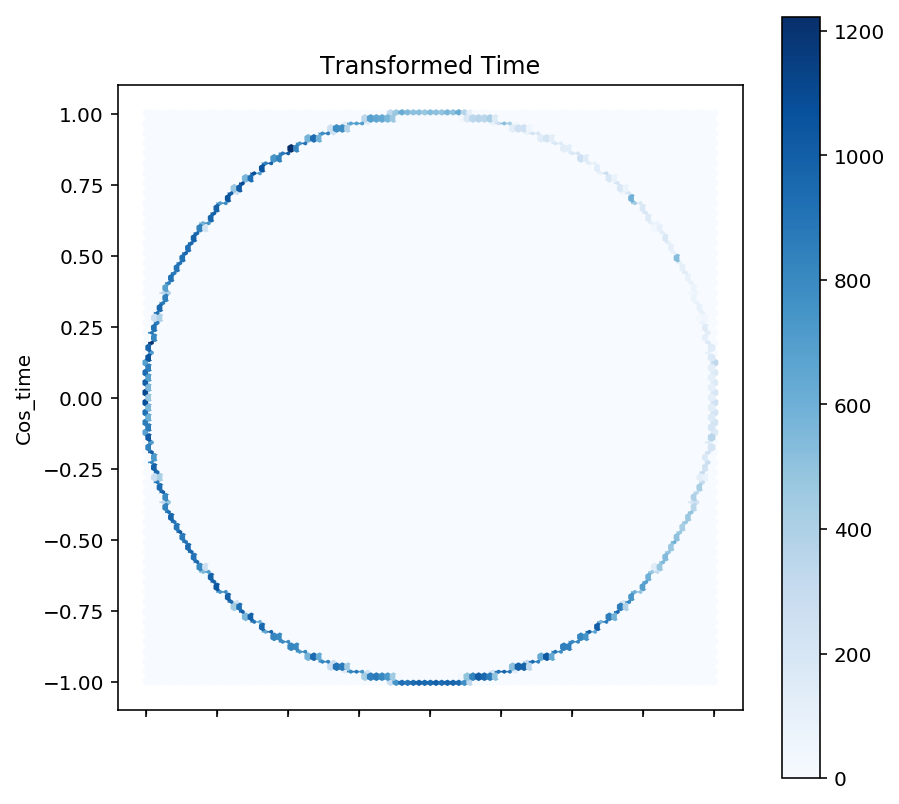

In [137]:
df.plot(x="Sin_time", y="Cos_time",
        kind="hexbin", figsize=(7, 7),
        cmap=plt.cm.Blues, title="Transformed Time").set_aspect("equal")

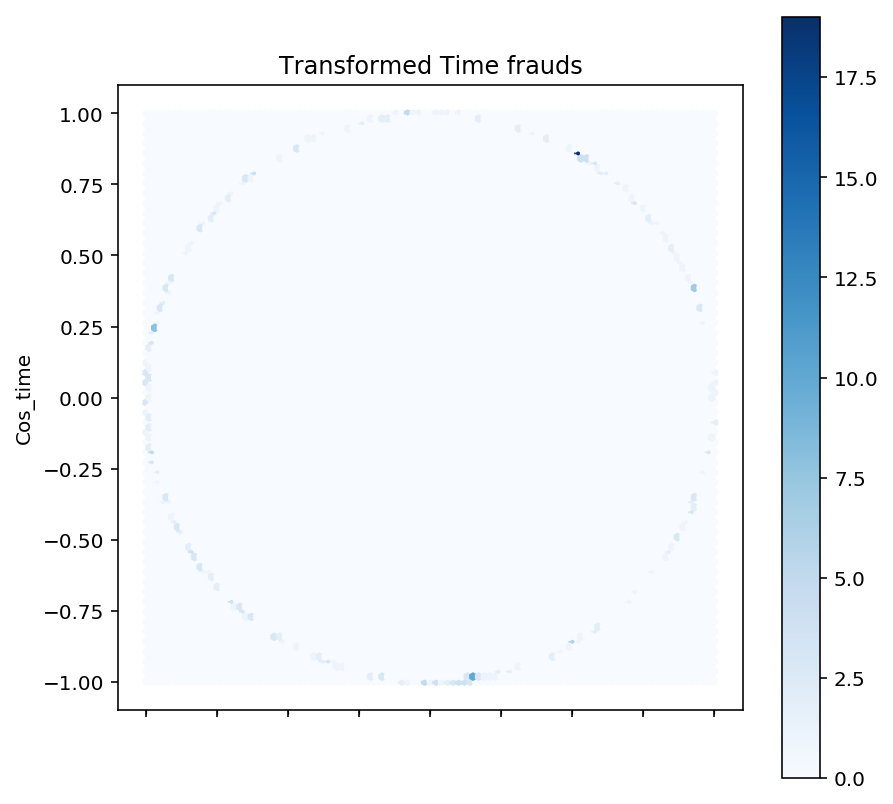

In [149]:
ax = df_frauds.plot(x="Sin_time", y="Cos_time",
        kind="hexbin", figsize=(7, 7),
        cmap=plt.cm.Blues, title="Transformed Time frauds")
ax.set_aspect("equal")

**Conclusion:** EDA conducted in this notebook shows patterns which occur in the data. Before building classification model, it might be beneficial to use strategies shown here to create additional features or transform existing (Amount, Time).

## Checking some models and setting baseline scores

**Load raw data again, because we transformed and created some features**

In [291]:
df = pd.read_csv("data\data1.csv")
df.drop(df.columns[0], inplace=True, axis=1) 

In [160]:
X = df.loc[:, df.columns != "Class"]
y = df["Class"]

In [158]:
def train_predict(model, X, y, test_size=0.3):
    """Function to automaticaly fit and predict given model.
    Returns evaluation metrics (Accuracy, Precision, Recall,
    F1 score, AUPRC)
    
    Input variables:
    model - object we want to test;
    X - object containing explanatory variables;
    y - object containing target variable;
    test_size - how much data should be used for testing.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                   random_state = 2019)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = np.round(accuracy_score(y_test, y_pred),3)
    prec = np.round(precision_score(y_test, y_pred),3)
    rec = np.round(recall_score(y_test, y_pred),3)
    f1 = np.round(f1_score(y_test, y_pred),3)
    auprc = np.round(average_precision_score(y_test, y_pred), 3)
    
    return acc, prec, rec, f1, auprc

In [161]:
models = [DummyClassifier(random_state=2019),
         LogisticRegression(random_state=2019),
         DecisionTreeClassifier(random_state=2019),
         RandomForestClassifier(random_state=2019),
         xgb.XGBClassifier(random_state=2019),
         GradientBoostingClassifier(random_state=2019)]

print("     Model     (accuracy, precision, recall, f1, auprc)  ")

for m in models:
    print(type(m).__name__, train_predict(m, X, y, test_size=0.3))

     Model     (accuracy, precision, recall, f1, auprc)  
DummyClassifier (0.997, 0.0, 0.0, 0.0, 0.002)
LogisticRegression (0.999, 0.747, 0.591, 0.66, 0.443)
DecisionTreeClassifier (0.999, 0.767, 0.687, 0.725, 0.527)
RandomForestClassifier (0.999, 0.932, 0.713, 0.808, 0.665)
XGBClassifier (0.999, 0.91, 0.704, 0.794, 0.642)
GradientBoostingClassifier (0.999, 0.779, 0.704, 0.74, 0.549)


**Lastly, let's check the performance of base models with transformations we suggested in this notebook. We will make several features / transformations:**
- 1/0 feature to check for 99.99 transactions concluded in groups;
- log(1+a) transformation of amount;
- adding sine and cosine transformation of time.

In [292]:
def feature_engineering(df):
    
    # Amount equal 99.99, transaction concluded in group 
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    df["Time"] = df["Time"] % 86400
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    df.drop("Time", axis=1, inplace=True)
    
    return df

In [293]:
df = feature_engineering(df)

In [297]:
df.head()  # A glimpse into modified data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Amount,Class,Amount_99_group,Sin_time,Cos_time
0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,...,0.504076,0.176423,0.541252,-0.121212,-0.064948,4.189503,0,0,0.143924,-0.989589
1,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,...,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,0.693147,0,0,-0.653255,-0.757138
2,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627285,2.452801,0.319063,-0.526330,...,0.091483,-0.038373,-0.410096,0.088944,0.026973,3.456317,0,0,-0.964365,0.264574
3,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,...,0.146116,0.342753,0.198887,-0.117734,-0.061706,5.044006,0,0,0.417537,-0.908660
4,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,...,0.049313,0.157236,0.606729,-0.063450,-0.071105,2.397895,0,0,0.572265,-0.820069


In [294]:
X = df.loc[:, df.columns != "Class"]
y = df["Class"]

In [295]:
print("     Model     (accuracy, precision, recall, f1, auprc)  ")

for m in models:
    print(type(m).__name__, train_predict(m, X, y, test_size=0.3))

     Model     (accuracy, precision, recall, f1, auprc)  
DummyClassifier (0.997, 0.0, 0.0, 0.0, 0.002)
LogisticRegression (0.999, 0.865, 0.557, 0.677, 0.482)
DecisionTreeClassifier (0.999, 0.774, 0.713, 0.742, 0.552)
RandomForestClassifier (0.999, 0.963, 0.678, 0.796, 0.654)
XGBClassifier (0.999, 0.909, 0.696, 0.788, 0.633)
GradientBoostingClassifier (0.999, 0.808, 0.73, 0.767, 0.59)


**Note:** We can see that performing feature engineering improved most AUPRC scores (except XGBClassifier and RandomForest).

**In next notebooks we will try tuning models to achieve better scores.**